# Builder Tutorial number 5

The builder tutorials demonstrate how to build an operational GSFLOW model using `pyGSFLOW` from shapefile, DEM, and other common data sources. These tutorials focus on the `gsflow.builder` classes.

## Building stream networks and cascade information for GSFLOW

In this tutorial, we demonstrate how to generate stream network and cascade routing information for GSFLOW models. The streamflow connectivity and cascade connectivity is needed to define the streamflow network in modflow's SFR package and to define stream and cascade connectivity in PRMS.

In [1]:
import os
import shapefile
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import flopy
from gsflow.builder import GenerateFishnet

### The `FlowAccumulation` class (refresher)

The `FlowAccumulation` class performs many operations including generating flow direction arrays and flow accumulation arrays. This example notebook focuses is on the `flow_direction` and `flow_accumulation` methods of this class. Other methods are presented in following tutorials.

The `FlowAccumulation` class has 3 required parameters and 5 optional input parameters:  

**REQUIRED Parameters**
   - `data` : resampled dem data array of dimension nrow, ncol (matches modelgrid dimension)
   - `xcenters` : a two dimensional array of x coordinate cell centers (dimension nrow, ncol)
   - `ycenters` : a two dimensional array of y coordinate cell centers (dimension nrow, ncol)

**OPTIONAL Parameters**
   - `acc_type` : flow accumlation type, currently only "d8" is supported
   - `hru_type` : optional hru_type array where 0=inactive, 1=land, 2=lake, and 3=swale
   - `closed_basin` : If true hru_type 2 is used in the flow direction calculations. False ignores hru_type 2. Default is False.
   - `flow_dir_array` : previously calculated flow direction array. This parameter is used to restart the class without performing flow direction analysis
   - `verbose` : boolean flag to print verbose output

Let's start with importing the class.

In [2]:
from gsflow.builder import FlowAccumulation

## Applying the methods to the Sagehen 50m example problem

In this example the methods are applied directly to the Sagehen 50m model as they are presented.

In [3]:
# define the input and output data paths
input_ws = os.path.join("data", "sagehen", "50m_tutorials")
shp_ws = os.path.join("data", "geospatial")
output_ws = os.path.join("data", "temp")

# define the modelgrid and resampled DEM data paths
mg_file = os.path.join(input_ws, "sagehen_50m_grid.bin")
dem_data = os.path.join(input_ws, "sagehen_50m_dem.txt")

# define the flow direction and flow accumulation data paths
flowdir_file = os.path.join(input_ws, "sagehen_50m_flowdir.txt")
flowacc_file = os.path.join(input_ws, "sagehen_50m_flowacc.txt")
watershed_file = os.path.join(input_ws, "sagehen_50m_watershed.txt")

# shapefile pour point
shp_file = os.path.join(shp_ws, "model_points.shp")

Load the previously processed data

In [4]:
# load modelgrid, dem, flow directions, and flow accumulation
modelgrid = GenerateFishnet.load_from_file(mg_file)
dem_data = np.genfromtxt(dem_data)
flow_directions = np.genfromtxt(flowdir_file, dtype=float)
flow_accumulation = np.genfromtxt(flowacc_file)
watershed = np.genfromtxt(watershed_file, dtype=int)

### Restarting the `FlowAccumulation` class from existing data

In this tutorial series, the flow direction and flow accumulation calculations were performed in the previous builder tutorial. Instead of re-running these calculations, which can be time consuming for very large models, we can provide the saved flow direction array to the class as a way of restarting the solution.

To restart from the previous solution, the saved flow direction array is passed to the `flow_dir_array` parameter during instantiation as shown in this example. For sagehen 50m the `watershed` variable is also passed to the `hru_type` array to define active and inactive cells for stream network and cascade generation. 

In [5]:
fa = FlowAccumulation(
    dem_data,
    modelgrid.xcellcenters,
    modelgrid.ycellcenters,
    hru_type=watershed,
    flow_dir_array=flow_directions,
    verbose=True
)

Now the `FlowAccumulation` object is ready to create stream network information and cascade information.

### Stream network creation

The stream network creation routine uses information from the stored flow direction and flow accumulation arrays to define stream cells. The user provides a contributing area threshold (represented by number of cells) that define a stream cell. If the flow accumulation array value is greater than the threshold, a given cell will be classified as a stream cell.

The `make_streams` method performs routines to classify and route streams and has the following parameters:

**REQUIRED parameters**
   - `fdir_array` : flow direction array
   - `fa_array` : flow accumulation array
   - `threshold` : accumulated area threshold, represented as number of cells, for defining streams

**OPTIONAL parameters**
   - `min_stream_length` : optional minimum stream length in number of cells
   - `max_reach` : optional maximum number of reach cells per stream segment
   - `default_slope` : optional default value for stream slope (defaults to 0.001), value is applied if slope cannot be calculated by cell center information.
   - `min_slope` : optional minimum value for stream slope (defaults to 0.0001)
   - `max_slope` : optional maximum value for stream slope (defaults to 1)

This example shows how to run `make_streams` using the required parameters

In [6]:
# create our threshold
threshold_m2 = 810000 
cellsize = 50
threshold = threshold_m2 / (cellsize ** 2)

# run make streams
strm_obj = fa.make_streams(
    flow_directions,
    flow_accumulation,
    threshold
)

**Data that's returned by `make_streams`**

The `make_streams` method returns a `_StreamsObj` that contains the following information as attributes:
   - `iseg` : an array of stream segment numbers
   - `ireach` : an array of stream reach numbers
   - `outseg` : an array of output segment connectivity
   - `irunbnd` : an array of land surface runoff routing to stream segments for UZF
   - `sfrtop` : an array of stream top elevation
   - `rchlen` : an array of reach length information
   - `slope` : an array of reach slopes
   - `aspect` : an array of cell aspects
   - `reach_data` : a ModflowSfr2 compatible recarray of the `reach_data` parameter
   - `segment_data` : a ModflowSfr2 compatible recarray of the ` segment_data` parameter
   

Let's inpect the `iseg` array:

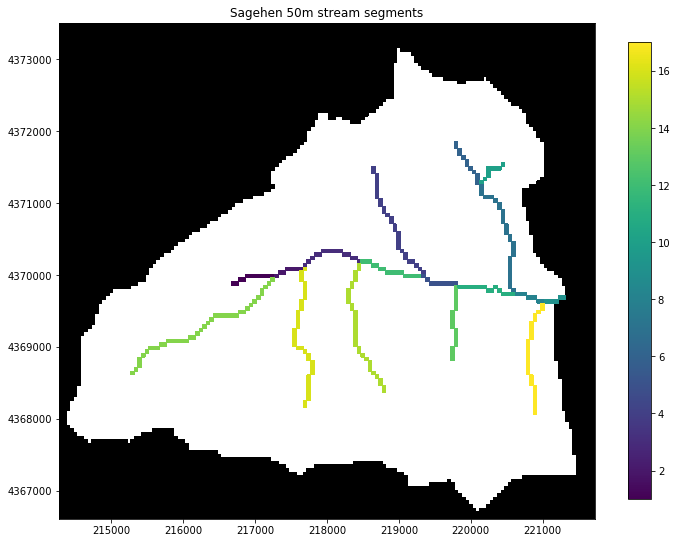

In [7]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
# plot the watershed boundary on top
ib = pmv.plot_ibound(ibound=watershed)
pc = pmv.plot_array(strm_obj.iseg, masked_values=[0,])

plt.colorbar(pc, shrink=0.7)
plt.title("Sagehen 50m stream segments")
plt.show();

### Cascade routing

Cascade routing calculates the connectivity of each hyrologic response unit in PRMS and connects this information to PRMS stream cells. The cascade routing calculation method is based on the Number of Input Drainage Paths (NIDP) method and allows for many cells to flow to a single cell, but a single cell can only flow downgradient to one neighbor.

The `get_cascades` method performs the cascade routing calculations and has the following parameters:

**REQUIRED parameters**
   - `streams` : Stream information object that is returned from the `make_streams()` method
   
**OPTIONAL parameters (required if watershed delineation has not been performed in the current script!)**
   - `pour_point` : three seperate input methods can be used to define the pour point as described below
      - list of [(xcoordinate, ycoordinate)] location that define the pour point
      - list of [(row, column)] location that define the pour point
      - shapefile name, file contains a single pour point that defines the basin outlet
   - `modelgrid` : modelgrid instance from `GenerateFishnet` (flopy.discretization.StructuredGrid object)
   - `fmt` : format of pour point input ("xy" for xy coordinates, "rowcol" for row column, "shp" for shapefile)
   
This example demonstrates how to create cascades when watershed delineation has not been performed in the current script.

In [8]:
# read in our pour point from a shapefile as an xy coordinate
with shapefile.Reader(shp_file) as r:
    shape = r.shape(0)
    pour_point = shape.points

print(pour_point)

[[221298.4058475063, 4369674.979622432]]


Now that the pour point is loaded cascade routing information can be calculated

In [9]:
cascades = fa.get_cascades(
    strm_obj,
    pour_point,
    modelgrid,
    fmt="xy"
)

flow_accumulation.py:768: UserWarning: running define watershed, watershed must be stored to run get_cascades
structuredgrid.py:777: UserWarning: The interface 'intersect(self, x, y, local=False, forgive=False)' has been deprecated. Use the intersect(self, x, y, z=None, local=False, forgive=False) interface instead.
structuredgrid.py:777: UserWarning: The interface 'intersect(self, x, y, local=False, forgive=False)' has been deprecated. Use the intersect(self, x, y, z=None, local=False, forgive=False) interface instead.


**Data returned by the `get_cascades` method**

The `get_cascades` method returns a `_Cascades` object that contains the following information as attributes:
   - `ncascade` : number of PRMS cascades
   - `hru_up_id` : numpy array of hru_up_id information for the hru_up_id parameter in PRMS
   - `hru_down_id` : numpy array of hru_down_id information for the hru_down_id parameter in PRMS
   - `hru_pct_up` : numpy array of hru_pct_up information for the hru_pct_up parameter in PRMS
   - `hru_strmseg_down_id` : numpy array of hru_strmseg_down_id for the hru_strmseg_down_id parameter in PRMS
   
Each of these data sets can be accessed using the following convention:

In [10]:
# get ncascades
print(cascades.ncascade)

10994


## Saving the stream information and cascade routing information for later use

The builder methods allow the user to save the stream information and cascade routing information as binary objects. This allows the user to pick up where they left off in another session or script.

These objects can be written to binary file by using the `write()` built in method.

*In the next tutorial we will load this information and begin building model files*

In [11]:
strm_obj.write(os.path.join(output_ws, "sagehen_50m_streams.bin"))
cascades.write(os.path.join(output_ws, "sagehen_50m_cascades.bin"))